In [1]:
import datetime
import requests
import ccxt
import numpy as np
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from dataset import Dataset
from binance_utils import get_all_coins, get_all_symbols
from binance import Client
from dotenv import dotenv_values
from scipy.optimize import curve_fit

In [2]:
def top_crypto(n=100):
    url = "https://api.coingecko.com/api/v3/coins/markets"
    params = {
        "vs_currency": "usd",
        "order": "market_cap_desc",
        "per_page": n,
        "page": 1,
        "sparkline": False,
    }
    
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()
        
        return data
    except requests.exceptions.HTTPError as e:
        print("Error retrieving data:", e)
        return None

In [3]:
coins = top_crypto(100)

In [4]:
len(coins)

100

In [5]:
config = dotenv_values('.env')
binance_client = Client(config.get('BINANCE_API_KEY'), config.get('BINANCE_API_SECRET'))

# Correlations

In [30]:
coins = [coin['symbol'].upper() for coin in top_crypto(500)]

In [31]:
binance_coins = get_all_coins()
binance_coins.sort()
print(len(binance_coins))

563


In [32]:
binance_symbols = get_all_symbols()
binance_symbols.sort()
print(len(binance_symbols))

2920


In [33]:
tickers = [c + 'USDT' for c in coins if c + 'USDT' in binance_symbols]
len(tickers)

67

In [34]:
ds = Dataset()

In [35]:
klines = ds.get_data(tickers[0], '4h', start_date='2024-1-1')

In [36]:
klines

,open,high,low,close,volume,quote asset volume,number of trades,taker buy base asset volume,taker buy quote asset volume
close_time,,,,,,,,,
2024-01-01 04:00:00,42283.58,42775.00,42230.08,42330.49,3948.08335,1.678186e+08,166013.0,2040.25881,8.672708e+07
2024-01-01 08:00:00,42330.50,42500.00,42180.77,42492.46,2706.99880,1.146432e+08,128552.0,1385.79272,5.868746e+07
2024-01-01 12:00:00,42492.46,42762.39,42452.58,42690.20,2948.80274,1.257459e+08,137484.0,1523.25695,6.495947e+07
2024-01-01 16:00:00,42690.21,42847.07,42580.00,42783.05,2936.44406,1.253587e+08,148756.0,1496.35093,6.387751e+07
2024-01-01 20:00:00,42783.05,43550.00,42664.42,43517.99,5686.97164,2.449706e+08,242235.0,3016.44908,1.299520e+08
...,...,...,...,...,...,...,...,...,...
2025-01-25 00:00:00,105760.93,105781.00,104456.89,104870.50,3295.43002,3.462474e+08,640187.0,1523.74773,1.600878e+08
2025-01-25 04:00:00,104870.51,105280.82,104361.89,105202.40,2029.85839,2.124959e+08,360315.0,1056.10863,1.105777e+08
2025-01-25 08:00:00,105202.40,105202.40,104216.81,104385.98,1407.20452,1.470741e+08,303337.0,628.59821,6.570080e+07


<AxesSubplot:xlabel='close_time'>

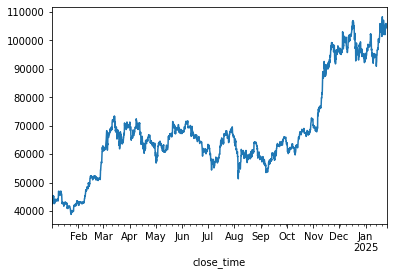

In [37]:
klines['close'].plot()

In [14]:
data = {}
for ticker in tickers:
    data[ticker] = ds.get_data(ticker, '4h', start_date='2024-1-1')['close']

In [15]:
cts = []
for dt in data.values():
    cts.append(dt.shape[0])
cts.sort()
cts

[0,
 0,
 0,
 105,
 153,
 301,
 472,
 676,
 892,
 970,
 1605,
 1660,
 1827,
 2019,
 2214,
 2214,
 2214,
 2214,
 2214,
 2214,
 2214,
 2214,
 2214,
 2214,
 2214,
 2214,
 2214,
 2214,
 2214,
 2214,
 2214,
 2214,
 2214,
 2214,
 2214,
 2214,
 2214,
 2214,
 2214,
 2214,
 2214,
 2214,
 2214,
 2214,
 2214,
 2214,
 2214,
 2214,
 2214,
 2214,
 2214,
 2214,
 2214,
 2214,
 2214,
 2214,
 2214,
 2214,
 2214,
 2214,
 2214,
 2214,
 2214,
 2214,
 2214,
 2214,
 2214,
 2214,
 2214,
 2214]

In [16]:
data_full = {key:val for key, val in data.items() if val.shape[0] == max(cts)}
data_full = pd.DataFrame.from_dict(data_full)

In [17]:
(data_full.std() / data_full.mean()).sort_values().head(10)

USDCUSDT     0.000626
FDUSDUSDT    0.001406
NEXOUSDT     0.162441
ETHUSDT      0.166994
LTCUSDT      0.196993
BNBUSDT      0.205749
ETCUSDT      0.211568
WBTCUSDT     0.224158
BTCUSDT      0.224809
SOLUSDT      0.240094
dtype: float64

In [18]:
data_full = data_full.drop(columns=['USDCUSDT', 'FDUSDUSDT', 'TUSDUSDT', 'PAXGUSDT'])

KeyError: "['TUSDUSDT', 'PAXGUSDT'] not found in axis"

In [ ]:
corr = data_full.corr()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax = sns.heatmap(corr)
plt.show()

In [ ]:
corr['BTCUSDT'].sort_values(ascending=True).head(10)

In [ ]:
corr['BTCUSDT'].sort_values(ascending=False).head(10)

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(data['BTCUSDT'] / data['BTCUSDT'].iloc[0])
plt.plot(data['ETHUSDT'] / data['ETHUSDT'].iloc[0])
plt.show()

# BTC

In [10]:
datetime.datetime.now()

datetime.datetime(2025, 1, 25, 16, 43, 16, 694679)

In [11]:
bitstamp = ccxt.bitstamp()

timeframe = '1d'

start_date = pd.Timestamp('2011-08-18')
end_date = datetime.datetime.now()

btc = pd.DataFrame()

while True:
    ohlcv = bitstamp.fetch_ohlcv('BTC/USD', timeframe, limit=1000, since=int(start_date.timestamp() * 1000))
    
    if len(ohlcv) == 0:
        break
    
    chunk_df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    chunk_df['timestamp'] = pd.to_datetime(chunk_df['timestamp'], unit='ms')
    chunk_df = chunk_df.set_index('timestamp', drop=True)
    chunk_df = chunk_df[chunk_df.index <= end_date]
    btc = pd.concat([btc, chunk_df])
    
    if chunk_df.index[-1] == end_date:
        break
    
    start_date = chunk_df.index[-1] + pd.Timedelta(days=1)

In [12]:
btc

,open,high,low,close,volume
timestamp,,,,,
2011-08-18,10.90,10.90,10.90,10.90,0.489908
2011-08-19,11.85,11.85,11.15,11.69,1.926578
2011-08-20,11.70,11.70,11.70,11.70,0.085470
2011-08-21,11.70,11.70,11.70,11.70,0.085470
2011-08-22,11.70,11.70,11.70,11.70,0.028632
...,...,...,...,...,...
2025-01-21,102155.00,107265.00,100087.00,106149.00,3058.410334
2025-01-22,106149.00,106370.00,103322.00,103632.00,1713.553688
2025-01-23,103659.00,106848.00,101233.00,103933.00,3790.173042


## EMA distance

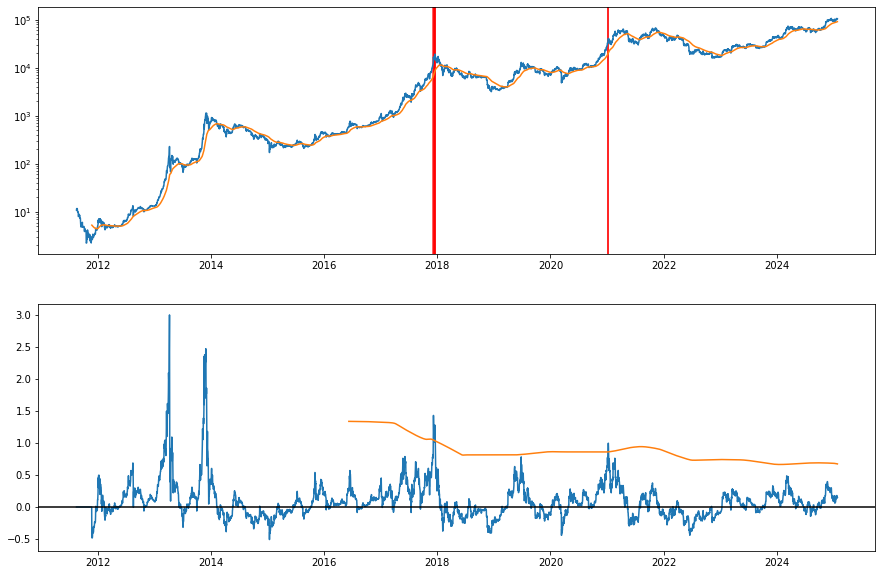

In [13]:
ma_len = 100
diff = (btc['close'] - btc.ta.ema(ma_len)) / btc.ta.ema(ma_len)
# thr = diff.mean() + 3 * diff.std()
# thr = diff.rolling(4*365).mean() + 3 * diff.rolling(4*365).std()
thr = (diff.rolling(4*365).mean() + 3 * diff.rolling(4*365).std()).rolling(200).mean()

fig, ax = plt.subplots(2, 1, figsize=(15, 10))
for i in range(btc[diff > thr].shape[0]):
    ax[0].axvline(btc[diff > thr].index[i], c='r', alpha=0.5)
ax[0].plot(btc['close'])
ax[0].plot(btc.ta.ema(ma_len))
ax[0].set_yscale('log')
ax[1].plot(diff.fillna(0))
plt.plot(thr)
ax[1].axhline(0, c='k')
plt.show()

### Risk

In [14]:
risk_ma = pd.Series(data=0, index=btc.index)
thrs = []
for ma_len in range(10, 201, 1):
    diff = (btc['close'] - btc.ta.ema(ma_len)) / btc.ta.ema(ma_len)
    thrs.append((diff.rolling(4*365).mean() + 3 * diff.rolling(4*365).std()).rolling(200).mean())
    risk_ma += diff

In [15]:
thr = pd.concat(thrs, axis=1).dropna().mean(axis=1)

In [16]:
risk_ma = risk_ma / thr
risk_ma = (risk_ma - risk_ma.min()) / (risk_ma.max() - risk_ma.min())

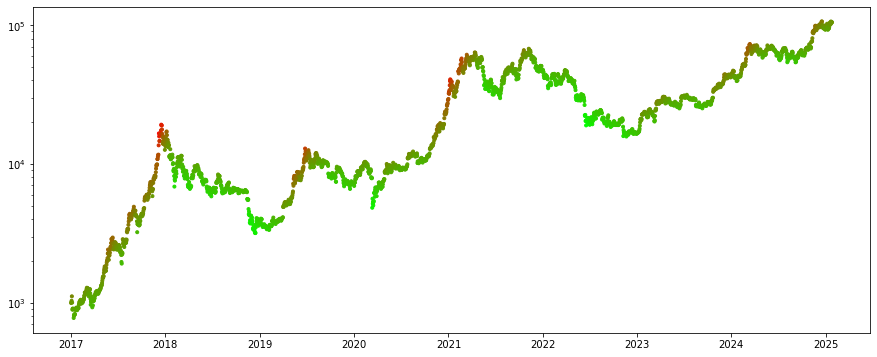

In [17]:
colors = [(0, 1, 0), (1, 0, 0)]
positions = [0, 1]  # Corresponding to low and high values
cmap = LinearSegmentedColormap.from_list('custom_cmap', list(zip(positions, colors)))

plt.figure(figsize=(15, 6))
plt.scatter(btc.loc['2017-1-1':].index, btc['close'].loc['2017-1-1':], marker='.',
            c=risk_ma.loc['2017-1-1':], cmap=cmap)
plt.yscale('log')
plt.show()

### Alarm

In [18]:
alarm = pd.Series(data=0, index=btc.index)

In [19]:
for ma_len in range(10, 201, 1):
    diff = (btc['close'] - btc.ta.ema(ma_len)) / btc.ta.ema(ma_len)
    thr = (diff.rolling(4*365).mean() + 3 * diff.rolling(4*365).std()).rolling(200).mean()
    alarm.loc[diff >= thr] += 1

In [20]:
alarm_n = alarm / alarm.max()

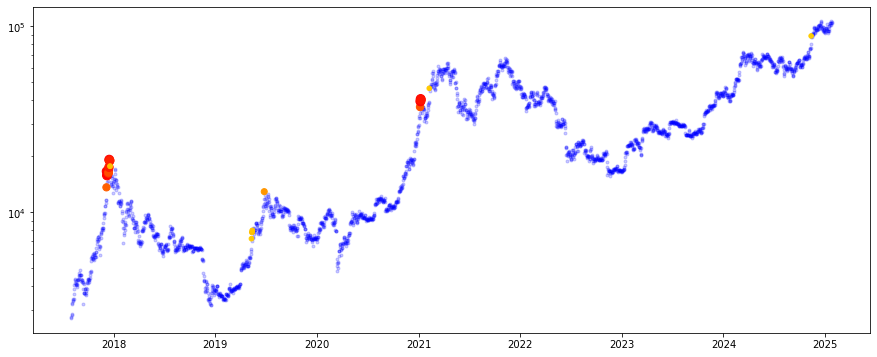

In [21]:
colors = [(1, 0.8, 0), (1, 0, 0)] # orange to red
positions = [0, 1]  # Corresponding to low and high values
cmap = LinearSegmentedColormap.from_list('custom_cmap', list(zip(positions, colors)))

plt.figure(figsize=(15, 6))
plt.scatter(btc[alarm_n==0].loc['2017-8-1':].index, btc[alarm_n==0]['close'].loc['2017-8-1':],
            marker='.', c='b', alpha=0.2)
plt.scatter(btc[alarm_n>0].loc['2017-8-1':].index, btc[alarm_n>0]['close'].loc['2017-8-1':],
            marker='o', c=alarm_n[alarm_n>0].loc['2017-8-1':], cmap=cmap,
            s=20 * (1 + 3 * alarm_n[alarm_n>0].loc['2017-8-1':]))
plt.yscale('log')
plt.show()

## Pi Cycle Top

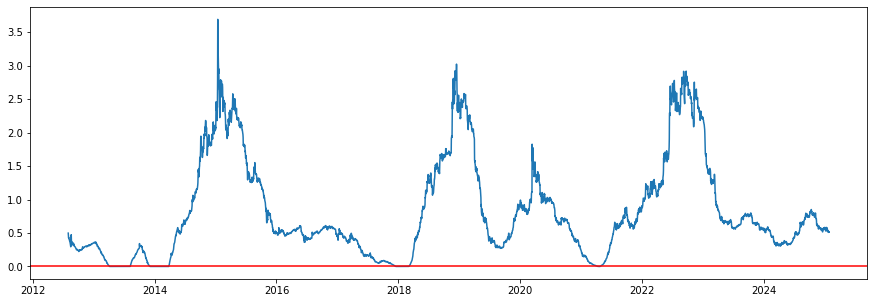

In [22]:
ma_diff = (btc.ta.sma(350) * 2 - btc.ta.sma(111)) / btc['close']
ma_diff[ma_diff < 0] = 0

plt.figure(figsize=(15, 5))
plt.plot(ma_diff)
plt.axhline(0, c='r')
plt.show()

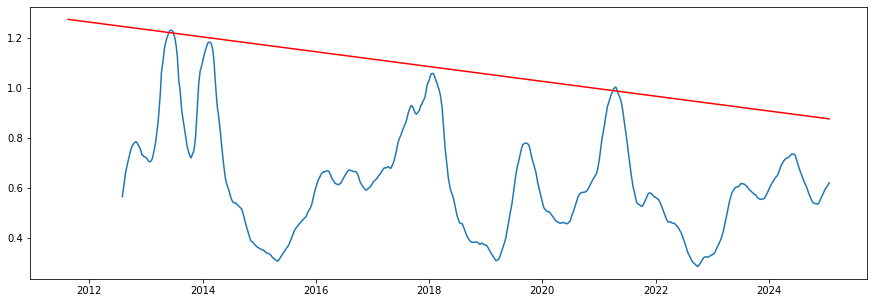

In [23]:
pi_ratio = (btc.ta.sma(111) / (btc.ta.sma(350) * 2))

x1 = np.where(pi_ratio.to_numpy()==pi_ratio.loc['2013-1-1':'2014-1-1'].to_numpy().max())[0][0]
y1 = pi_ratio.loc['2013-1-1':'2014-1-1'].to_numpy().max()
x2 = np.where(pi_ratio.to_numpy()==pi_ratio.loc['2015-1-1':'2019-1-1'].to_numpy().max())[0][0]
y2 = pi_ratio.loc['2015-1-1':'2019-1-1'].to_numpy().max()
x3 = np.where(pi_ratio.to_numpy()==pi_ratio.loc['2019-1-1':'2022-1-1'].to_numpy().max())[0][0]
y3 = pi_ratio.loc['2019-1-1':'2022-1-1'].to_numpy().max()

x_data = np.array([x1, x2, x3])
y_data = np.array([y1, y2, y3])

def linear_func(x, m, c):
    return m * x + c

params, covariance = curve_fit(linear_func, x_data, y_data)
m, c = params

x_fit = range(pi_ratio.shape[0])
y_fit = linear_func(x_fit, m, c)
y_fit = pd.Series(data = y_fit, index=pi_ratio.index)

plt.figure(figsize=(15, 5))
plt.plot(pi_ratio)
plt.plot(y_fit, c='r')
plt.show()

### Alarm

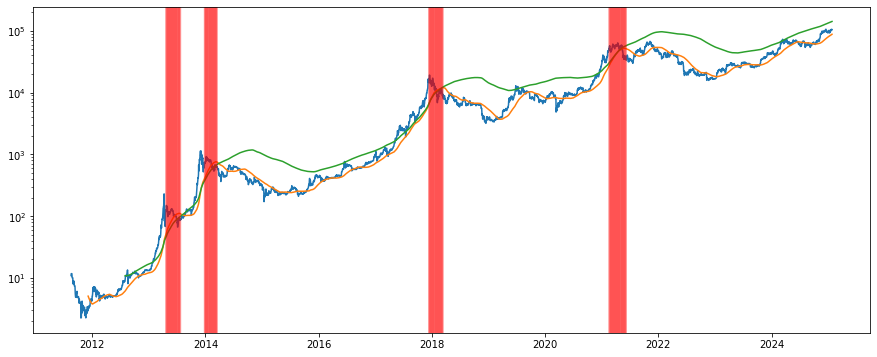

In [24]:
plt.figure(figsize=(15, 6))
plt.plot(btc['close'])
plt.plot(btc.ta.sma(111))
plt.plot(btc.ta.sma(350) * 2)
# for idx in ma_diff[ma_diff == 0].index:
#     plt.axvline(idx, c='r', alpha=0.1)
for idx in pi_ratio[pi_ratio >= 0.9 * y_fit].index:
    plt.axvline(idx, c='r', alpha=0.1)
plt.yscale('log')
plt.show()

### Risk

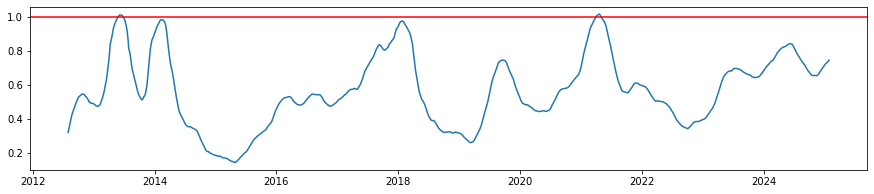

In [25]:
# risk_pi = ma_diff / ma_diff.max()
# risk_pi = 1 - risk_pi
# risk_pi **= 10
risk_pi = 1 - (y_fit - pi_ratio)

plt.figure(figsize=(15, 3))
plt.plot(risk_pi)
plt.axhline(1, c='r')
plt.show()

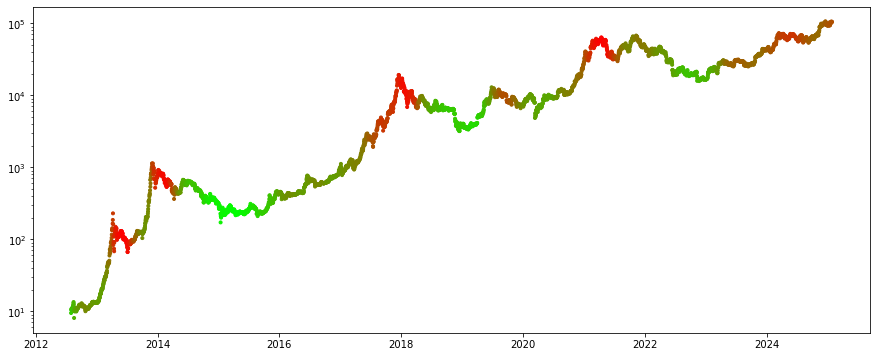

In [26]:
colors = [(0, 1, 0), (1, 0, 0)]
positions = [0, 1]  # Corresponding to low and high values
cmap = LinearSegmentedColormap.from_list('custom_cmap', list(zip(positions, colors)))

plt.figure(figsize=(15, 6))
plt.scatter(btc.index, btc['close'], marker='.', c=risk_pi, cmap=cmap)
plt.yscale('log')
plt.show()

## Cumulative risk

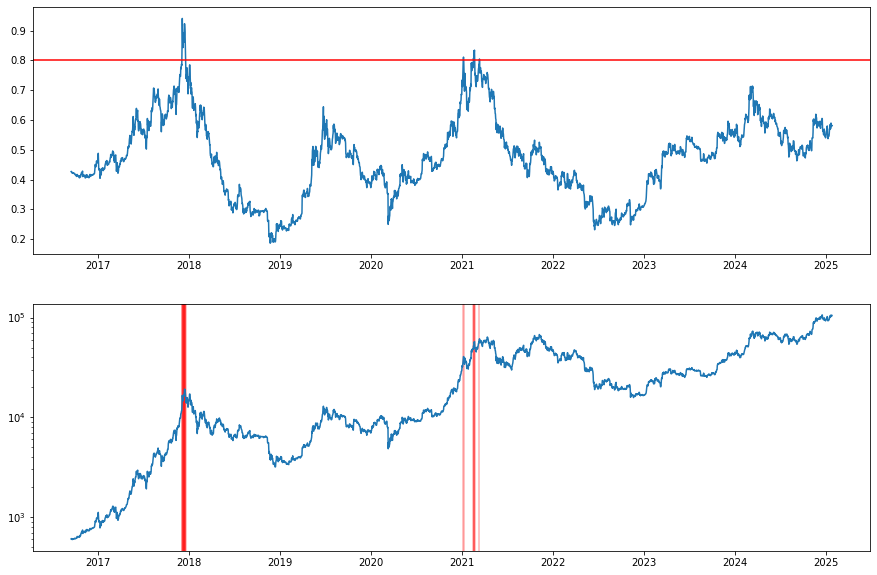

In [27]:
risk_cum = (risk_ma + risk_pi) / 2

fig, ax = plt.subplots(2, 1, figsize=(15, 10))
ax[0].plot(risk_cum.dropna())
ax[0].axhline(0.8, c='r')
for idx in risk_cum[risk_cum >= 0.8].index:
    ax[1].axvline(idx, c='r', alpha=0.3)
ax[1].plot(btc['close'].loc[risk_cum.dropna().index])
ax[1].set_yscale('log')
plt.show()

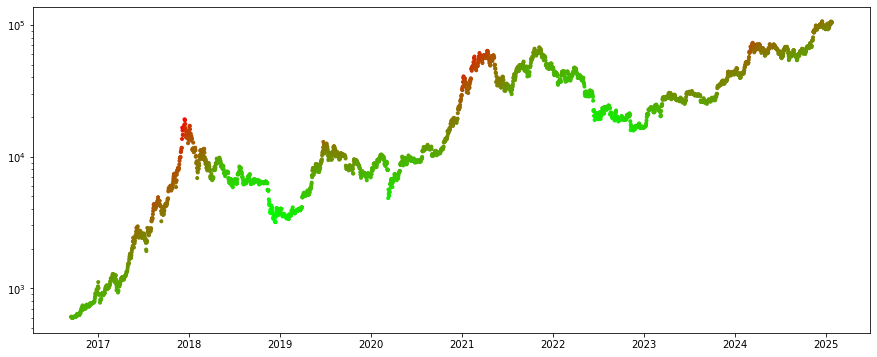

In [28]:
colors = [(0, 1, 0), (1, 0, 0)]
positions = [0, 1]  # Corresponding to low and high values
cmap = LinearSegmentedColormap.from_list('custom_cmap', list(zip(positions, colors)))

plt.figure(figsize=(15, 6))
plt.scatter(btc.index, btc['close'], marker='.', c=risk_cum, cmap=cmap)
plt.yscale('log')
plt.show()

# SOL

In [38]:
sol = ds.get_data('SOLUSDT', '1d', start_date='2020-1-1')

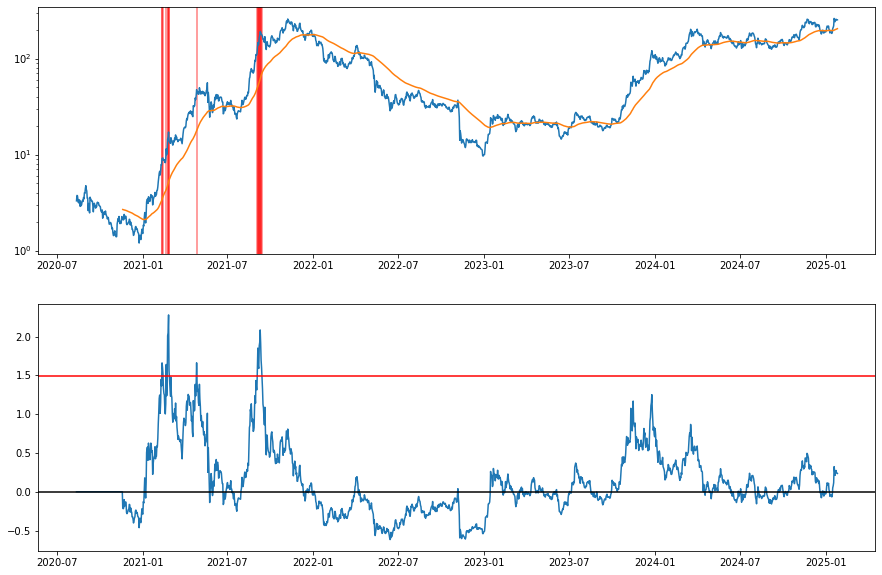

In [39]:
ma_len = 100
diff = (sol['close'] - sol.ta.ema(ma_len)) / sol.ta.ema(ma_len)
thr = diff.mean() + 3 * diff.std()

fig, ax = plt.subplots(2, 1, figsize=(15, 10))
for i in range(sol[diff > thr].shape[0]):
    ax[0].axvline(sol[diff > thr].index[i], c='r', alpha=0.5)
ax[0].plot(sol['close'])
ax[0].plot(sol.ta.ema(ma_len))
ax[0].set_yscale('log')
ax[1].plot(diff.fillna(0))
ax[1].axhline(thr, c='r')
ax[1].axhline(0, c='k')
plt.show()

# FET

In [40]:
fet = ds.get_data('FETUSDT', '1d', start_date='2020-1-1')

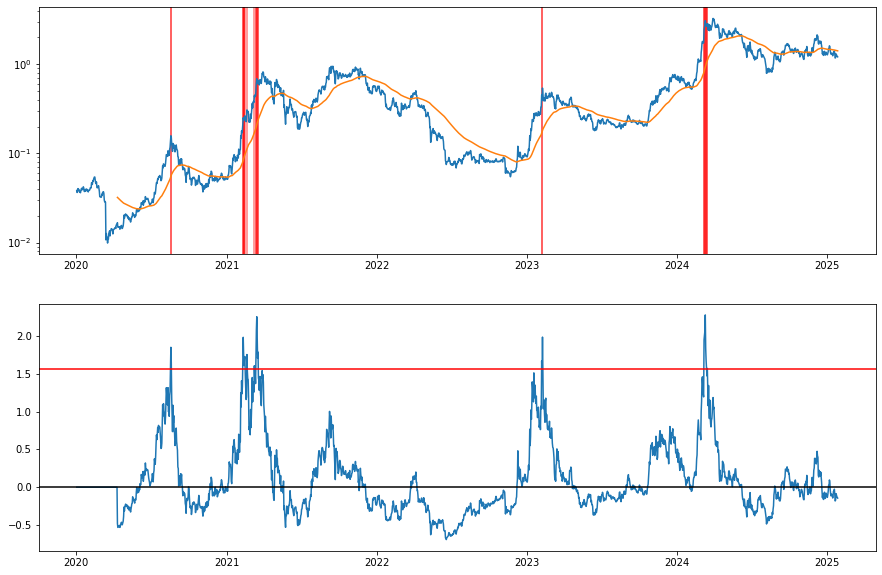

In [41]:
ma_len = 100
diff = (fet['close'] - fet.ta.ema(ma_len)) / fet.ta.ema(ma_len)
thr = diff.mean() + 3 * diff.std()

fig, ax = plt.subplots(2, 1, figsize=(15, 10))
for i in range(fet[diff > thr].shape[0]):
    ax[0].axvline(fet[diff > thr].index[i], c='r', alpha=0.5)
ax[0].plot(fet['close'])
ax[0].plot(fet.ta.ema(ma_len))
ax[0].set_yscale('log')
ax[1].plot(diff.fillna(0))
ax[1].axhline(thr, c='r')
ax[1].axhline(0, c='k')
plt.show()

# DOGE

In [42]:
doge = ds.get_data('DOGEUSDT', '1d', start_date='2020-1-1')

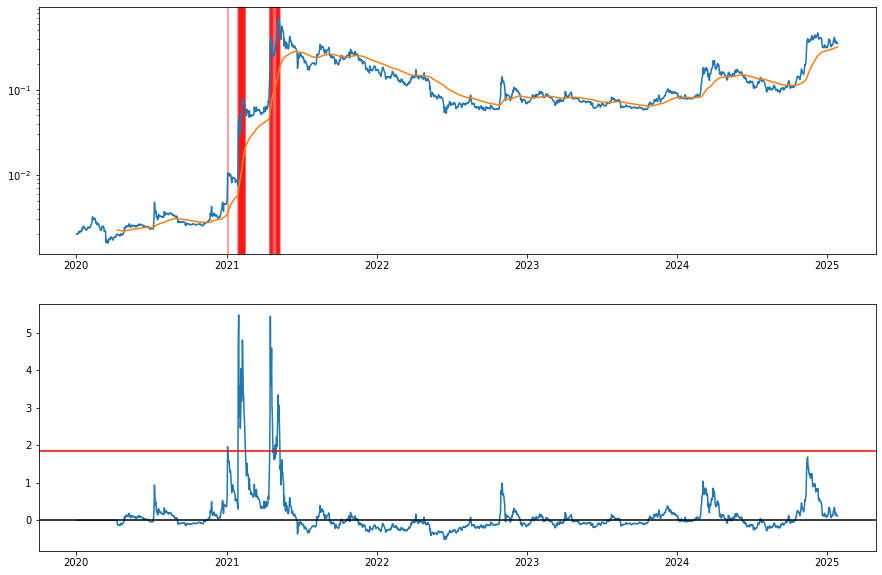

In [43]:
ma_len = 100
diff = (doge['close'] - doge.ta.ema(ma_len)) / doge.ta.ema(ma_len)
thr = diff.mean() + 3 * diff.std()

fig, ax = plt.subplots(2, 1, figsize=(15, 10))
for i in range(doge[diff > thr].shape[0]):
    ax[0].axvline(doge[diff > thr].index[i], c='r', alpha=0.5)
ax[0].plot(doge['close'])
ax[0].plot(doge.ta.ema(ma_len))
ax[0].set_yscale('log')
ax[1].plot(diff.fillna(0))
ax[1].axhline(thr, c='r')
ax[1].axhline(0, c='k')
plt.show()